
# What is a calibration curve?

Before we dive into how to interpret a calibration curve, let's start by getting
intuitions on what it graphically represents. In this exercise, you will build your
own calibration curve.

To simplify the process, we only focus on the output of a binary classifier but
without going into details on the model used to generate the predictions. We later
discuss the implications of the data modeling process on the calibration curve.

So let's first generate some predictions. The generative process is located in the
file `_generate_predictions.py`. This process stores the true labels and the
predicted probability estimates of several models into the `predictions` folder.

In [1]:
# Equivalent to the magic command "%run _generate_predictions.py" but it allows this
# file to be executed as a Python script.
from IPython import get_ipython

ipython = get_ipython()
ipython.run_line_magic("run", "../python_files/_generate_predictions.py")


Let's load a the true labels and the predicted probabilities of one of the models.

In [2]:
import numpy as np

y_true = np.load("../predictions/y_true.npy")
y_prob = np.load("../predictions/y_prob_2.npy")

In [3]:
y_true

array([0, 0, 1, ..., 0, 1, 0])


`y_true` contains the true labels. In this case, we face a binary classification
problem.

In [4]:
y_prob

array([0.01301041, 0.51749109, 0.73808646, ..., 0.09744258, 0.22943148,
       0.36252617])


`y_prob` contains the predicted probabilities of the positive class estimated by a
given model.

As discussed earlier, we could evaluate the discriminative power of the model using
a metric such as the ROC-AUC score.

In [5]:
from sklearn.metrics import roc_auc_score

print(f"ROC AUC: {roc_auc_score(y_true, y_prob):.2f}")

ROC AUC: 0.80



The score is much above 0.5 and it means that our model is able to discriminate
between the two classes. However, this score does not tell us if the predicted
probabilities are well calibrated.

We can provide an example of a well-calibrated probability: for a given sample, the
predicted probabilities is considered well-calibrated if the proportion of samples
where this probability is predicted is equal to the probability itself.

It is therefore possible to group predictions into bins based on their predicted
probabilities and to calculate the proportion of positive samples in each bin and
compare it to the average predicted probability in the bin.

Scikit-learn provide a utility to plot this graphical representation. It is available
through the class `sklearn.calibration.CalibrationDisplay`.

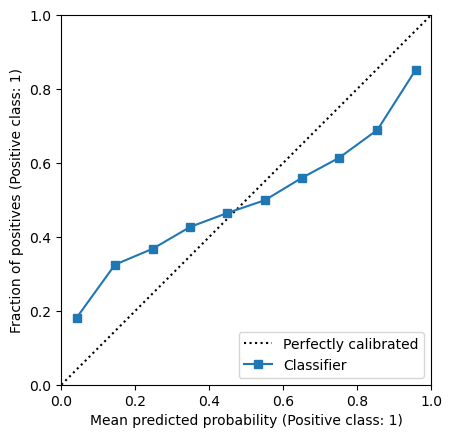

In [6]:
from sklearn.calibration import CalibrationDisplay

n_bins = 10
disp = CalibrationDisplay.from_predictions(
    y_true, y_prob, n_bins=n_bins, strategy="uniform"
)
_ = disp.ax_.set(xlim=(0, 1), ylim=(0, 1), aspect="equal")


As a pedagogical exercise, we will build the calibration curve from scratch. This
will help us understand the underlying process. The calibration curve is built by
following these steps:

1. Bin the predicted probabilities (i.e. `y_prob`) into 10 bins. You can use the
   `pd.cut` function from the `pandas` library. It will return a `Categorical`
   object where we get the bin identifier for each sample.

In [7]:
import pandas as pd

bin_identifier = pd.cut(y_prob, bins=n_bins)


2. Create a DataFrame with the true labels, predicted probabilities, and bin
   identifier.

In [8]:
predictions = pd.DataFrame(
    {
        "y_true": y_true,
        "y_prob": y_prob,
        "bin_identifier": bin_identifier,
    }
)
predictions

,y_true,y_prob,bin_identifier
0,0,0.013010,"(0.00603, 0.106]"
1,0,0.517491,"(0.5, 0.599]"
2,1,0.738086,"(0.697, 0.796]"
3,1,0.968531,"(0.895, 0.993]"
4,0,0.442157,"(0.401, 0.5]"
...,...,...,...
49995,1,0.980434,"(0.895, 0.993]"
49996,0,0.931823,"(0.895, 0.993]"
49997,0,0.097443,"(0.00603, 0.106]"
49998,1,0.229431,"(0.204, 0.303]"



3. Group the DataFrame by the bin identifier and calculate the mean of the true
   labels and the predicted probabilities.

In [9]:
avg_predicted_probabilities = predictions.groupby(
    "bin_identifier", observed=True
).y_prob.mean()
fraction_positive_samples = predictions.groupby(
    "bin_identifier", observed=True
).y_true.mean()


4. Plot the calibration curve by plotting the average predicted probabilities
   against the fraction of positive samples.

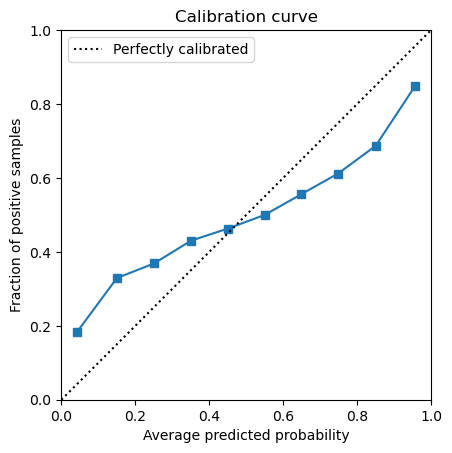

In [10]:
import matplotlib.pyplot as plt

_, ax = plt.subplots()
ax.plot(avg_predicted_probabilities, fraction_positive_samples, "s-")
ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax.legend()
_ = ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    xlabel="Average predicted probability",
    ylabel="Fraction of positive samples",
    aspect="equal",
    title="Calibration curve",
)


Scikit-learn also provides a parameter `strategy` that is the strategy to adopt to
create the bins. By default, we used the `"uniform"` strategy. However, it can happen
that only few samples are present in some bins, leading to a noisy calibration curve.

The strategy `"quantile"` ensures that each bin has the same number of samples. We
can show it on our previous example:

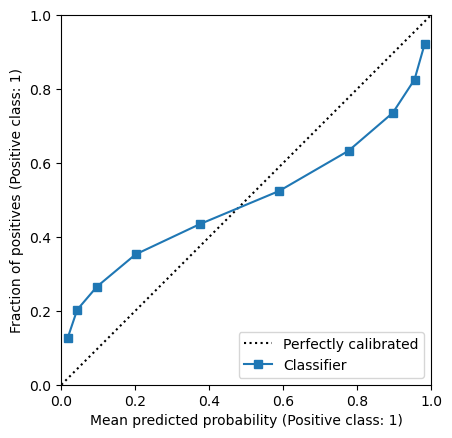

In [11]:
disp = CalibrationDisplay.from_predictions(
    y_true, y_prob, n_bins=n_bins, strategy="quantile"
)
_ = disp.ax_.set(xlim=(0, 1), ylim=(0, 1), aspect="equal")


Modify your previous implementation such that `pd.cut` uses quantiles to create the
bins instead of the default uniform behaviour. Specifically, look at the `bins`
parameter and the function `np.quantile`.

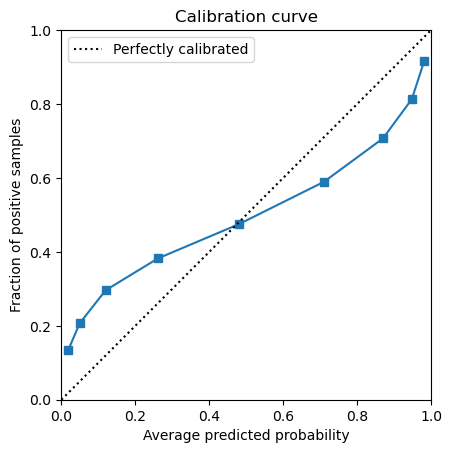

In [12]:
bin_identifier = pd.cut(y_prob, bins=np.quantile(y_prob, np.linspace(0, 1, n_bins)))
predictions = pd.DataFrame(
    {
        "y_true": y_true,
        "y_prob": y_prob,
        "bin_identifier": bin_identifier,
    }
)
avg_predicted_probabilities = predictions.groupby(
    "bin_identifier", observed=True
).y_prob.mean()
fraction_positive_samples = predictions.groupby(
    "bin_identifier", observed=True
).y_true.mean()
_, ax = plt.subplots()
ax.plot(avg_predicted_probabilities, fraction_positive_samples, "s-")
ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax.legend()
_ = ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    xlabel="Average predicted probability",
    ylabel="Fraction of positive samples",
    aspect="equal",
    title="Calibration curve",
)